<a href="https://colab.research.google.com/github/s-thandri/labelflipping/blob/main/german_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on
def s_parity(test_data, predictors, prediction_df, sensitive_attr, sensitive_attr_cutoff, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: credit_risk_12
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]<sensitive_attr_cutoff]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]>=sensitive_attr_cutoff]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] < sensitive_attr_cutoff)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] >= sensitive_attr_cutoff)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [3]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def decision_tree(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=622)
        clf = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3, min_samples_leaf=5)
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

In [4]:
#Load data
columns = ["checking_account_status", "duration", "credit_history", "purpose", "credit_amount", "savings_account_status", "employment_status", "installment_rate", "personal_status", "other_debtors", "residence_since", "property", "age", "other_installment_plans", "housing", "existing_credits", "job", "num_dependents", "telephone", "foreign_worker", "credit_risk"]
german_df = pd.read_table('german.data', header = None, delim_whitespace=True, names = columns)

In [6]:
#Encode the categorical columns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
encoded_data = pd.get_dummies(german_df,columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)

In [7]:
#Standardize the numeric columns
numeric_col = ['duration','credit_amount','installment_rate','residence_since','age','existing_credits','num_dependents']
scaler = StandardScaler()
encoded_data[numeric_col] = scaler.fit_transform(encoded_data[numeric_col])

In [8]:
#Drop the credit_risk (Labels) column
X = encoded_data.drop(['credit_risk'], axis=1)

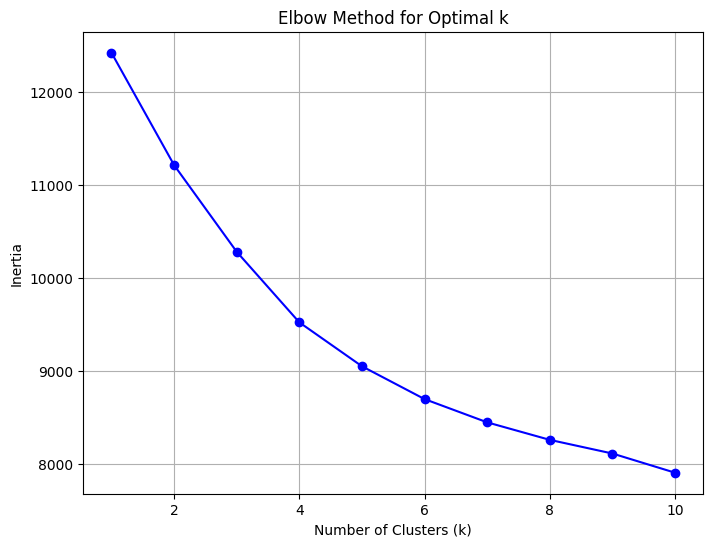

In [9]:
#Elbow method to figure out the number of clusters

# Initialize an empty list to store the inertia (variance) for different values of k
inertia = []

# Test different values of k (number of clusters) and compute the inertia for each
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [10]:
#Perform K-means clustering
k = 5
kmeans = KMeans(n_clusters = k, random_state = 42)
encoded_data["cluster"] = kmeans.fit_predict(X)

In [11]:
#Visualize the clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

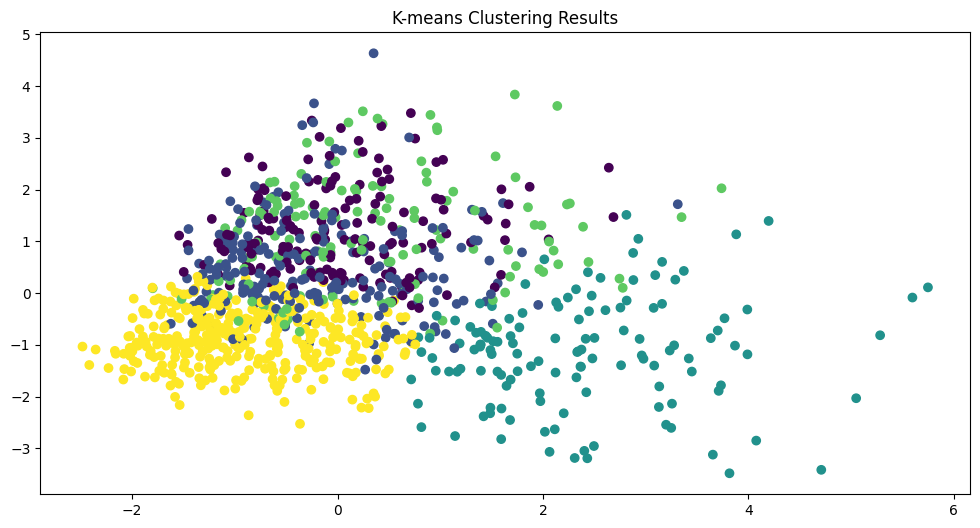

In [12]:
# Plot the data points with cluster assignments
plt.figure(figsize=(12, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=encoded_data["cluster"], cmap="viridis")
plt.title("K-means Clustering Results")
plt.show()

In [13]:
# Select the binary attribute of interest, "credit_risk"
attribute_of_interest = "credit_risk"

#Create a contingency table to calculate the distribution of "credit_risk" in each cluster
#This tells me how many datapoints in each cluster
#And what the label distribution of each datapoint is
contingency_table = pd.crosstab(encoded_data["cluster"], encoded_data[attribute_of_interest])

In [14]:
#Converts the 'cluster' column to a list
cluster_list = encoded_data['cluster'].tolist()
#Makes a copy of the original dataframe
gd_copy = german_df.copy()
#Appends the 'cluster' column from the previous dataframe onto this one
gd_copy['cluster'] = cluster_list

In [15]:
#Groups the information inthe dataframe based on their cluster membership
grouped_dataframes = gd_copy.groupby('cluster', as_index=False)
#Splits the data up based on the cluster
#e.g. if i want all the information belonging to cluster 1 i do cluster_dataframes[1]
cluster_dataframes = [group for _, group in grouped_dataframes]


In [17]:
#Get the unique values from cluster_list to be able to loop through and calculate acc and parity
unique_clust = list(set(cluster_list))

In [18]:
#Initialize all the different columns including predictors and target variable
target_var = 'credit_risk'
predictors = ['duration', 'credit_amount', 'installment_rate', 'residence_since',
       'age', 'existing_credits', 'num_dependents',
       'checking_account_status_A12', 'checking_account_status_A13',
       'checking_account_status_A14', 'credit_history_A31',
       'credit_history_A32', 'credit_history_A33', 'credit_history_A34',
       'savings_account_status_A62', 'savings_account_status_A63',
       'savings_account_status_A64', 'savings_account_status_A65',
       'employment_status_A72', 'employment_status_A73',
       'employment_status_A74', 'employment_status_A75', 'personal_status_A92',
       'personal_status_A93', 'personal_status_A94', 'other_debtors_A102',
       'other_debtors_A103', 'property_A122', 'property_A123', 'property_A124',
       'other_installment_plans_A142', 'other_installment_plans_A143',
       'housing_A152', 'housing_A153', 'job_A172', 'job_A173', 'job_A174',
       'telephone_A192', 'foreign_worker_A202', 'purpose_A41',
       'purpose_A42', 'purpose_A43', 'purpose_A45',
       'purpose_A46', 'purpose_A49']

In [19]:
#Loop through each cluster and calculate the parity and accuracy of each one
for x in unique_clust:
  #Encode each dataframe to make calculations
  cluster_data_encoded = pd.get_dummies(cluster_dataframes[x],columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)
  #Set the credit_risk as int type
  cluster_data_encoded['credit_risk'] = cluster_data_encoded['credit_risk'].astype(int)
  #Calculate accuracy
  accuracy,test_datapoints, test_prediction = decision_tree(cluster_data_encoded, predictors, target_var, 'credit_risk_12')
  #Calculate parity
  parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')

  print(f'Cluster{x}:{accuracy}')
  print(f'Cluster{x}:{parity}\n')



Cluster0:79.41176470588235
Cluster0:0.0

Cluster1:83.33333333333334
Cluster1:-0.2564102564102565

Cluster2:69.23076923076923
Cluster2:-0.028571428571428525

Cluster3:82.75862068965517
Cluster3:0.050724637681159424

Cluster4:66.19718309859155
Cluster4:0.19999999999999996



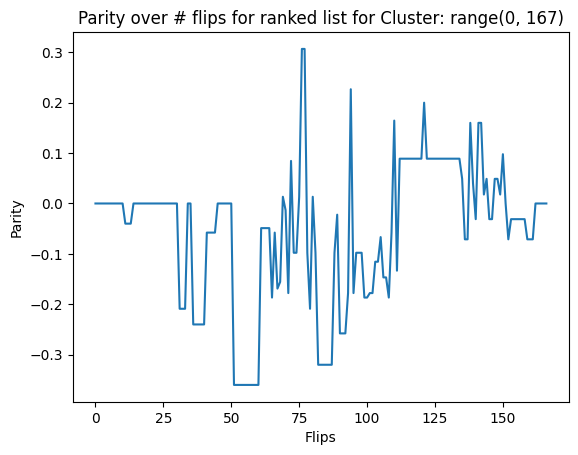

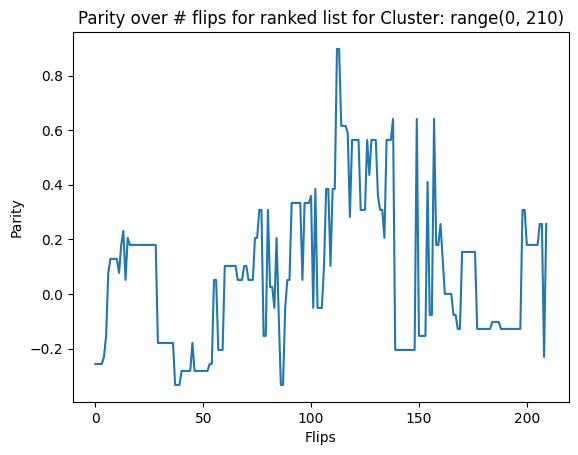

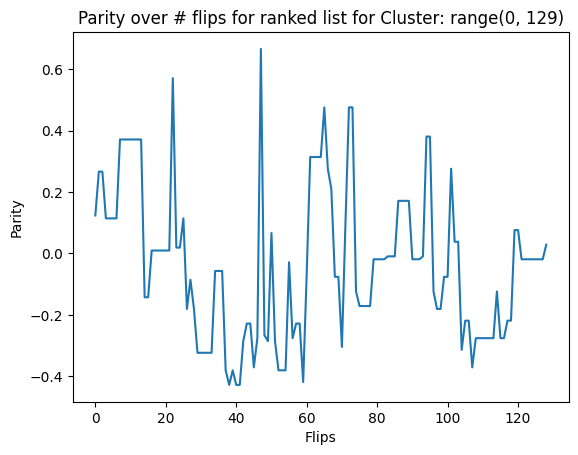

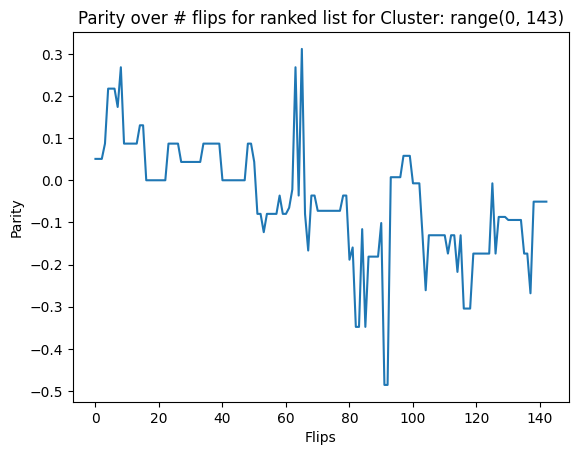

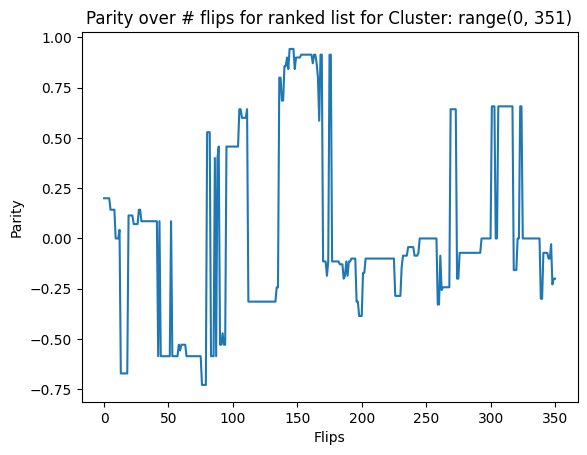

In [30]:
#After calculating the parity and accuracy I flip labels in each cluster and recalculate per flip
for x in unique_clust:
  #Encode the data first
  cluster_data_encoded = pd.get_dummies(cluster_dataframes[x],columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)
  #Convert the credit_risk to a integer type
  cluster_data_encoded['credit_risk'] = cluster_data_encoded['credit_risk'].astype(int)

  #Check to see what the value of credit_risk is in each dataframe
  #If value is 1 then flip to 2 and calculate accuracy and lparity
  #If 2 flip to 1 and calculate accuracy and parity
  #Do this for each cluster_dataframe
  list_acc = []

  list_parity = []
  for index, row in cluster_data_encoded.iterrows():


    if row['credit_risk'] == 1:
      cluster_data_encoded.at[index, 'credit_risk'] = 2
      accuracy,test_datapoints, test_prediction = decision_tree(cluster_data_encoded, predictors, target_var, 'credit_risk_12')
      #Calculate parity
      parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
      list_acc.append(accuracy)
      list_parity.append(parity)

    elif row['credit_risk'] == 2:
      cluster_data_encoded.at[index,'credit_risk'] = 1
      #Calculate Accuracy
      accuracy,test_datapoints, test_prediction = decision_tree(cluster_data_encoded, predictors, target_var, 'credit_risk_12')
      #Calculate parity
      parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
      list_acc.append(accuracy)
      list_parity.append(parity)

  #Plot of the information in the order of the flips of parity
  x=range(len(list_parity))

  #Plot the data
  plt.plot(x,list_parity)

  #Add the labels
  plt.xlabel('Flips')
  plt.ylabel('Parity')
  plt.title(f'Parity over # flips for ranked list for Cluster: {x}')

  #Show the plot
  plt.show()

  #break




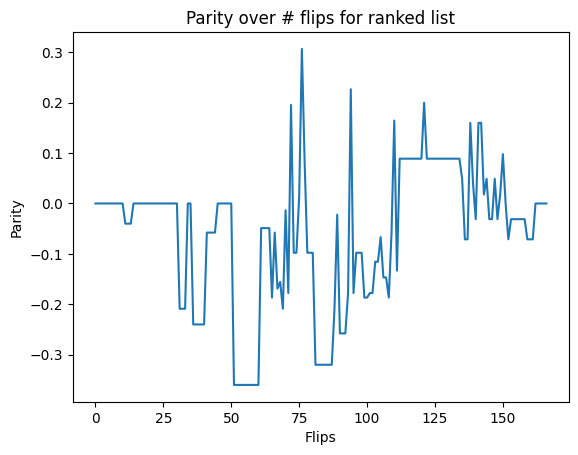

In [24]:
#Plot of the information in the order of the flips of parity
x=range(len(list_parity))

#Plot the data
plt.plot(x,list_parity)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips for ranked list')

#Show the plot
plt.show()

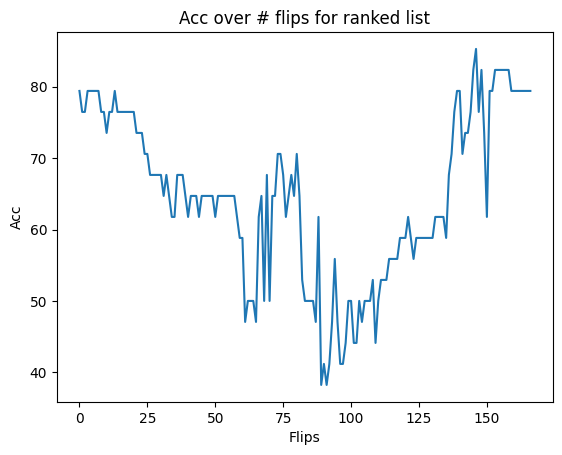

In [25]:
#Plot of the information in the order of the flips of parity
x=range(len(list_acc))

#Plot the data
plt.plot(x,list_acc)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Acc')
plt.title('Acc over # flips for ranked list')

#Show the plot
plt.show()